In [1]:
#! pip install chardet


import folium 
import chardet


import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt 


from pandas import Series, DataFrame
from folium import Marker, GeoJson
from geopandas import GeoSeries
from shapely.geometry import Point, LineString
from folium.plugins import MarkerCluster, HeatMap

# Data reading and cleaning

In [2]:
base = open(r'../../_data/data_dengue_peru.csv','rb').read()
det = chardet.detect(base)
charenc = det['encoding']

# Reading data
df = pd.read_csv(r'../../_data/data_dengue_peru.csv', encoding = charenc)

# Generating Ubigeo as string, cause not all Ubigeo values are of 6 digits
df["Ubigeo_str"]  = df['Ubigeo'].astype(str).str.zfill(6)

# Identifying department
df["Ubigeo_dep"]  = df["Ubigeo_str"].str[0:2].astype(int)

# Identifying province
df["Ubigeo_prov"] = df["Ubigeo_str"].str[0:4].astype(int)

# Capital letter to merge
df.columns = df.columns.str.upper()

# Casos formatting
df["CASOS"] = df["CASOS"].astype(str)
df["CASOS"] = df["CASOS"].replace(',','',regex=True)
df["CASOS"] = df["CASOS"].astype(float)
#df["CASOS"] = df["CASOS"].fillna(0)
#df["CASOS"] = df["CASOS"].astype(int)

# Dataframe pre visualization
df

C:\Users\josed\anaconda3\envs\geoentorno\lib\site-packages\IPython\core\interactiveshell.py:3251: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,AÑO,SEMANA,EVENTOS O DAÑOS,DEPARTAMENTO,DISTRITO,PROVINCIA,UBIGEO,CASOS,UBIGEO_STR,UBIGEO_DEP,UBIGEO_PROV
0,2020,43,Dengue,CUSCO,MEGANTONI,LA CONVENCION,80914,2.0,080914,8,809
1,2021,41,Dengue,MOQUEGUA,MOQUEGUA,MARISCAL NIETO,180101,NaN,180101,18,1801
2,2021,42,Dengue,MOQUEGUA,MOQUEGUA,MARISCAL NIETO,180101,NaN,180101,18,1801
3,2020,1,Dengue,CUSCO,MEGANTONI,LA CONVENCION,80914,0.0,080914,8,809
4,2020,53,Dengue,CUSCO,MEGANTONI,LA CONVENCION,80914,2.0,080914,8,809
...,...,...,...,...,...,...,...,...,...,...,...
172139,2021,49,Dengue,MADRE DE DIOS,MADRE DE DIOS,MANU,170203,NaN,170203,17,1702
172140,2021,49,Dengue,MADRE DE DIOS,TAHUAMANU,TAHUAMANU,170303,NaN,170303,17,1703
172141,2021,50,Dengue,MADRE DE DIOS,MADRE DE DIOS,MANU,170203,NaN,170203,17,1702
172142,2021,50,Dengue,MADRE DE DIOS,TAHUAMANU,TAHUAMANU,170303,NaN,170303,17,1703


# Cases by district

<AxesSubplot:>

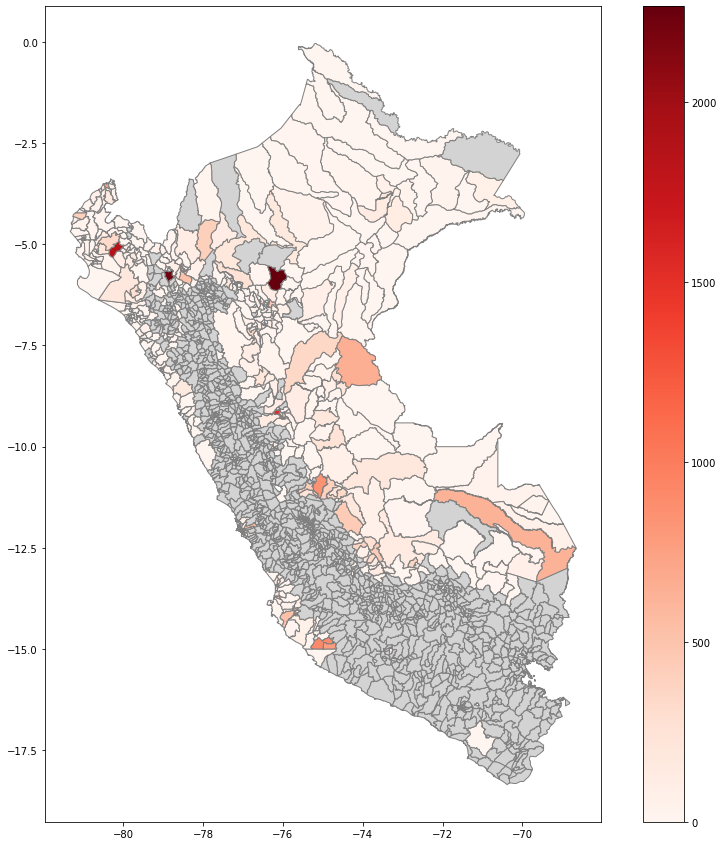

In [3]:
shape_1 = gpd.read_file(r'../../_data/LIMITE_DISTRITAL_2020_INEI/INEI_LIMITE_DISTRITAL.shp')
shape_1['UBIGEO'] = shape_1['UBIGEO'].astype(str).astype(int)


# General cases by district 2021 data frame 
cases_dist_2021 = df.loc[df['AÑO'] == 2021]

# Cases by district
dist_21 = cases_dist_2021.groupby(['UBIGEO'])[['CASOS']].sum()
dist_21["UBIGEO"] = dist_21.index
dist_21.reset_index(drop=True, inplace=True)
dist_21

# Cases by district georeferenced
cases_dist = pd.merge(shape_1, dist_21, how="outer", on="UBIGEO")

# Plot
cases_dist.plot( column='CASOS', cmap='Reds', 
          figsize=(15, 15),
          linestyle='-',
          edgecolor='gray',
          legend = True,
          missing_kwds={"color": "lightgrey"})

# Cases by province

<AxesSubplot:>

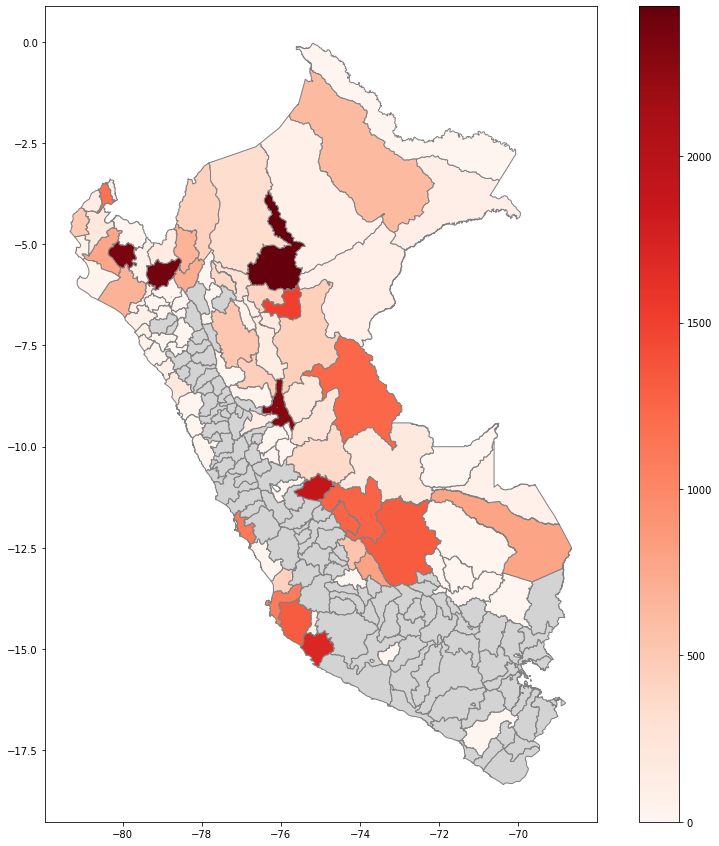

In [4]:
shape_2 = gpd.read_file(r'../../_data/LIMITE_DISTRITAL_2020_INEI/INEI_LIMITE_DISTRITAL.shp')

# Generating Ubigeo as string, cause not all Ubigeo values are of 6 digits
shape_2["UBIGEO_STR"]  = shape_2['UBIGEO'].astype(str).str.zfill(6)

# Generate province ID
shape_2["UBIGEO_PROV"] = shape_2["UBIGEO_STR"].str[0:4].astype(int)
shape_2['UBIGEO'] = shape_2['UBIGEO'].astype(str).astype(int)

# Agregating shapes by Province
shape_2_prov = shape_2.dissolve(by='UBIGEO_PROV')

# General cases by district 2021 data frame 
cases_prov_2021 = df.loc[df['AÑO'] == 2021]

# Cases by province
prov_21 = cases_prov_2021.groupby(['UBIGEO_PROV'])[['CASOS']].sum()
prov_21["UBIGEO_PROV"] = prov_21.index
prov_21.reset_index(drop=True, inplace=True)


# Cases by province georeferenced
cases_prov = pd.merge(shape_2_prov, prov_21, how="outer", on="UBIGEO_PROV")

# Plot
cases_prov.plot( column='CASOS', cmap='Reds', 
          figsize=(15, 15),
          linestyle='-',
          edgecolor='gray',
          legend = True,
          missing_kwds={"color": "lightgrey"})

# Cases by department and year

Generating departamental data

In [5]:
shape_3 = gpd.read_file(r'../../_data/LIMITE_DISTRITAL_2020_INEI/INEI_LIMITE_DISTRITAL.shp')

# Generating Ubigeo as string, cause not all Ubigeo values are of 6 digits
shape_3["UBIGEO_STR"]  = shape_3['UBIGEO'].astype(str).str.zfill(6)

# Generate province ID
shape_3["UBIGEO_DEP"] = shape_3["UBIGEO_STR"].str[0:2].astype(int)
shape_3['UBIGEO'] = shape_3['UBIGEO'].astype(str).astype(int)

# Agregating shapes by department
shape_3_dep = shape_3.dissolve(by='UBIGEO_DEP')

# Generating departmental data
dep = df.groupby(['UBIGEO_DEP','AÑO'])[['CASOS']].sum()
dep["UBIGEO_DEP"] = dep.index.get_level_values(0)
dep["AÑO"] = dep.index.get_level_values(1)
dep.reset_index(drop=True, inplace=True)
dep.sort_values('AÑO')

,CASOS,UBIGEO_DEP,AÑO
0,37.0,1,2015
126,220.0,22,2015
105,32.0,19,2015
98,0.0,18,2015
49,3.0,11,2015
...,...,...,...
27,2555.0,6,2021
118,4010.0,20,2021
111,358.0,19,2021
13,26.0,2,2021


Generating data frames by year

In [6]:
year_list = [2015, 2016, 2017, 2018, 2019, 2020, 2021]


cases_dep = {}
dep_year = {}

for i in range(len(year_list)):
    cases_dep[year_list[i]] = dep.loc[dep['AÑO'] == year_list[i]]
    dep_year[year_list[i]] = pd.merge(shape_3_dep, cases_dep[year_list[i]], how="outer", on="UBIGEO_DEP")

Plotting data

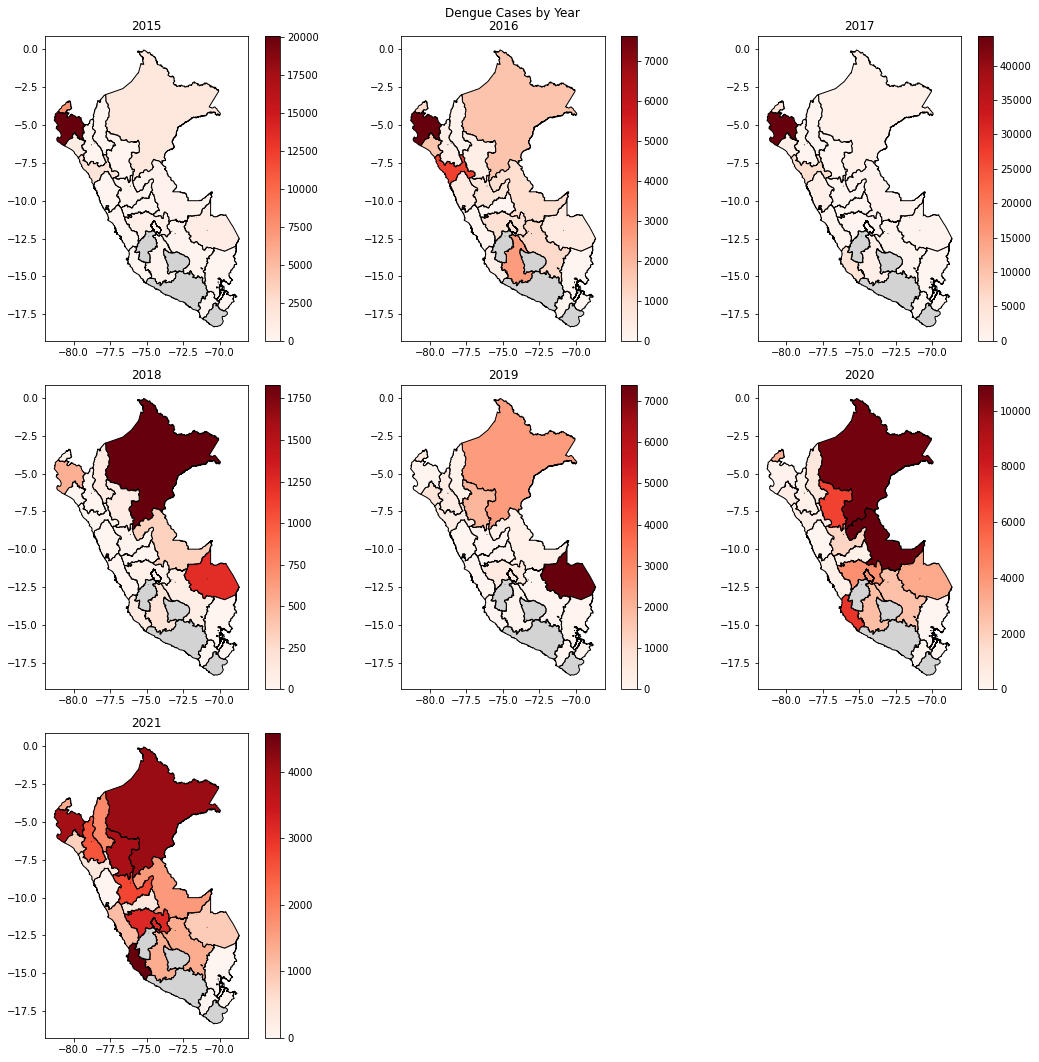

In [7]:
# A small function that hellps us for automatic subplots dimmensions
from math import sqrt
def nearest_square(num):
         num1 = round(sqrt(num))**2
         return int(sqrt(num1))

# Figure set up
fig, axis = plt.subplots( nrows = nearest_square(len(year_list)),
                         ncols= nearest_square(len(year_list)),
                         figsize = ( 15, 15 ) )

# Loop for subplot
idx = 0
for i in range( nearest_square(len(year_list)) ):
    for j in range ( nearest_square(len(year_list)) ):
        
        # if idx is minor to number of elements
        if idx <= len(year_list) - 1:
            ax = axis[ i ][ j ]

            dep_year[year_list[idx]].plot( column='CASOS', 
                      cmap='Reds', 
                      linestyle='-',
                      edgecolor='black',
                      legend = True, 
                      ax = ax,
                      missing_kwds={"color": "lightgrey"}
                    )

            ax.set_title( year_list[idx] )

            idx = idx + 1
            
        # if idx is major to number of elements        
        else:
        
            axis[i,j].axis('off')
            idx = idx + 1
            
fig.suptitle('Dengue Cases by Year')
fig.tight_layout()

# Cases by department and 2021 quarters

Generating data by quarters

In [8]:
# Generate Quarter data
df["QUARTER"] = ((df["SEMANA"]-1) // 13) + 1
df.loc[df.QUARTER == 5, 'QUARTER'] = 4

# Generating departmental data
quarter = df.groupby(['UBIGEO_DEP','AÑO','QUARTER'])[['CASOS']].sum()
quarter["UBIGEO_DEP"] = quarter.index.get_level_values(0)
quarter["AÑO"] = quarter.index.get_level_values(1)
quarter["QUARTER"] = quarter.index.get_level_values(2)
quarter.reset_index(drop=True, inplace=True)
quarter.sort_values('AÑO')


# Generate Georeferenced Quarter data
quarter_list = [1, 2, 3, 4]


cases_dep_q = {}
dep_quarter = {}

for i in range(len(quarter_list)):
    cases_dep_q[quarter_list[i]] = quarter.loc[(quarter['QUARTER'] == quarter_list[i]) & (quarter["AÑO"] == 2021)]
    dep_quarter[quarter_list[i]] = pd.merge(shape_3_dep, cases_dep_q[quarter_list[i]], how="outer", on="UBIGEO_DEP")

Plotting data

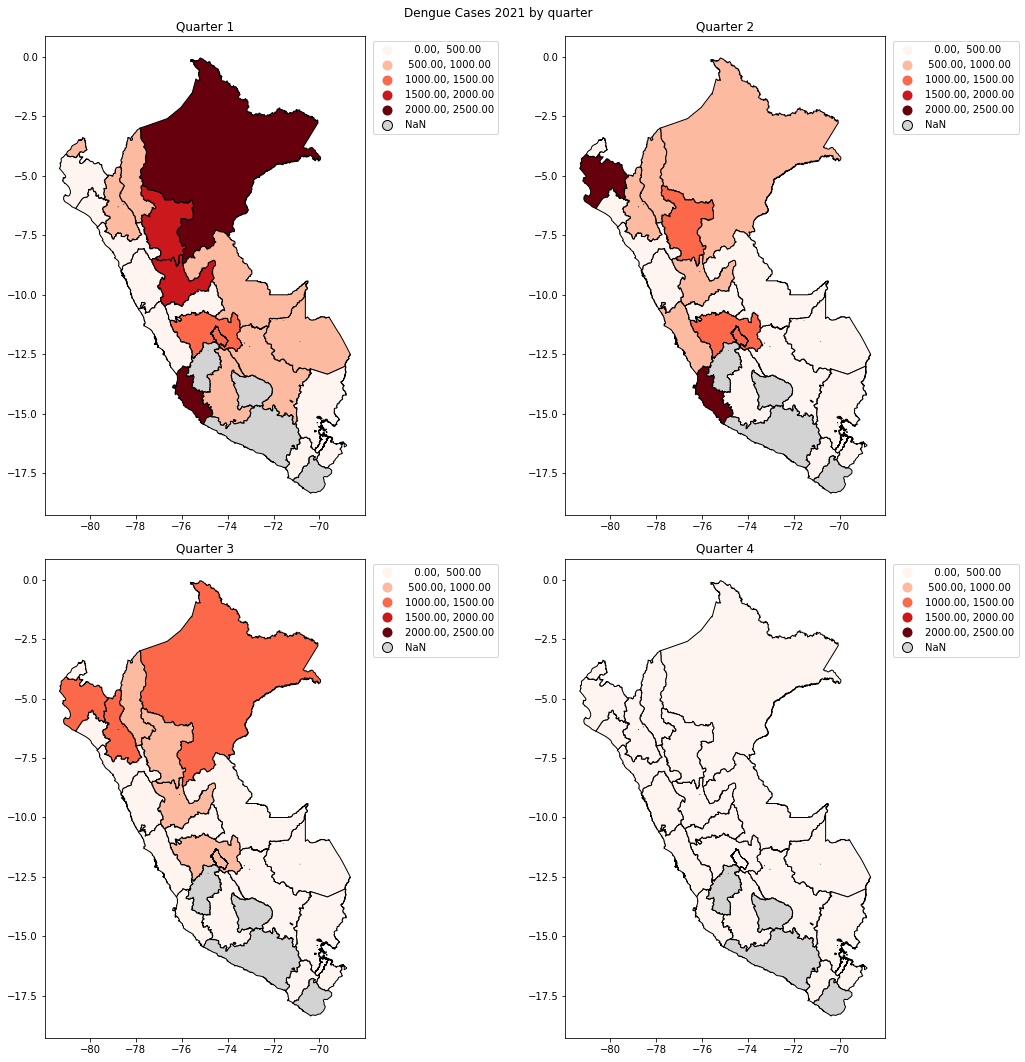

In [9]:
# A small function that hellps us for automatic subplots dimmensions
from math import sqrt
def nearest_square(num):
         num1 = round(sqrt(num))**2
         return int(sqrt(num1))

# Figure set up
fig, axis = plt.subplots( nrows = nearest_square(len(quarter_list)),
                         ncols= nearest_square(len(quarter_list)),
                         figsize = ( 15, 15 ) )

# Loop for subplot
idx = 0
for i in range( nearest_square(len(quarter_list)) ):
    for j in range ( nearest_square(len(quarter_list)) ):
        
        # if idx is minor to number of elements
        if idx <= len(quarter_list) - 1:
            ax = axis[ i ][ j ]

            dep_quarter[quarter_list[idx]].plot( column='CASOS', 
                      cmap='Reds', 
                      linestyle='-',
                      edgecolor='black',
                      legend = True, 
                      ax = ax,
                      missing_kwds={"color": "lightgrey"},
                      scheme = "User_Defined",                           
                      classification_kwds = dict( bins = [500, 1000, 1500, 2000, 2500] ),
                      legend_kwds=dict(  loc='upper left',
                                       bbox_to_anchor=(1.01, 1))                          
                    )

            ax.set_title( 'Quarter ' + str(quarter_list[idx]) )

            idx = idx + 1
            
        # if idx is major to number of elements        
        else:
        
            axis[i,j].axis('off')
            idx = idx + 1
            
fig.suptitle('Dengue Cases 2021 by quarter')
fig.tight_layout()